#### Packages & Load Data

In [75]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import mutual_info_score
from sklearn.preprocessing import StandardScaler
from scipy import stats

In [76]:
file = "database/dfT_result.csv"
fileEX = "database/上市公司內外銷資料.xlsx"
df = pd.read_csv(file, encoding='big5')
dfEX = pd.read_excel(fileEX)

In [77]:
desired_ex = ['代號', '生產值(千元)', '外銷比率％']
dfEX = dfEX[desired_ex]

df = df.merge(dfEX, on='代號', how='outer')
df = df.dropna(subset=['industry_id'])
df['industry_id'] = df['industry_id'].astype(int)
print(df)

       代號  industry_id LEVEL_111   E1   E9  E10  E17   Q4   Q7  Q11  ...  G19  \
0    1101           14        B+  2.0  2.0  4.0  3.0  4.0  4.0  1.0  ...  2.0   
1    1102           14         A  4.0  3.0  1.0  4.0  3.0  4.0  2.0  ...  3.0   
2    1103           14         B  2.0  4.0  1.0  4.0  2.0  2.0  1.0  ...  4.0   
3    1104           14        B+  2.0  2.0  2.0  2.0  2.0  2.0  1.0  ...  2.0   
4    1108           14         B  4.0  4.0  2.0  4.0  3.0  3.0  1.0  ...  4.0   
..    ...          ...       ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
704  9938            3        B+  2.0  2.0  1.0  4.0  1.0  2.0  1.0  ...  4.0   
705  9939           15        B+  4.0  2.0  1.0  4.0  1.0  1.0  1.0  ...  4.0   
706  9942           22         B  4.0  2.0  1.0  4.0  1.0  1.0  1.0  ...  3.0   
707  9944            3        B-  4.0  4.0  1.0  4.0  1.0  1.0  1.0  ...  3.0   
708  9958           16         B  4.0  4.0  1.0  4.0  1.0  1.0  1.0  ...  3.0   

     Q34_2  Q35_2  E_score 

In [78]:
df['外銷比率％'].describe()

count    705.000000
mean      63.067518
std       34.519705
min       -4.800000
25%       33.950000
50%       77.090000
75%       92.470000
max      100.000000
Name: 外銷比率％, dtype: float64

In [79]:
df['外銷比重'] = pd.cut(df['外銷比率％'], bins=[0, 0.0001, 10, 20, 30, 40, 50, 100], include_lowest=True, 
       labels = ['0%(無外銷)', '外銷比例超過0%~10%', '外銷比例超過10%~20%', '外銷比例超過20%~30%', '外銷比例超過30%~40%', '外銷比例超過40%~50%', '外銷比例超過50%'])
df.groupby('外銷比重')['外銷比重'].count()

外銷比重
0%(無外銷)           31
外銷比例超過0%~10%      73
外銷比例超過10%~20%     24
外銷比例超過20%~30%     35
外銷比例超過30%~40%     26
外銷比例超過40%~50%     37
外銷比例超過50%        478
Name: 外銷比重, dtype: int64

In [80]:
df['生產值(千元)'].describe()

count    6.790000e+02
mean     2.979282e+07
std      1.709841e+08
min      3.586000e+03
25%      1.605310e+06
50%      3.929906e+06
75%      1.198619e+07
max      3.721130e+09
Name: 生產值(千元), dtype: float64

In [81]:
df['生產值(元)'] = pd.cut(df['生產值(千元)'], bins=[0, 100000, 200000, 500000, 1000000, 2000000, 5000000, 10000000, 20000000, 50000000, 100000000, 4000000000], include_lowest=True, 
       labels = ['1億以下', '1億~2億', '2億~5億', '5億~10億', '10億~20億', '20億~50億', '50億~100億', '100億~200億', '200億~500億', '500億~1000億', '大於1000億'])
df.groupby('生產值(元)')['生產值(元)'].count()

生產值(元)
1億以下           11
1億~2億           7
2億~5億          39
5億~10億         48
10億~20億       102
20億~50億       166
50億~100億      105
100億~200億      86
200億~500億      55
500億~1000億     30
大於1000億        30
Name: 生產值(元), dtype: int64

##### 依產業別(industry_id)分析

c:\Users\mayda\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


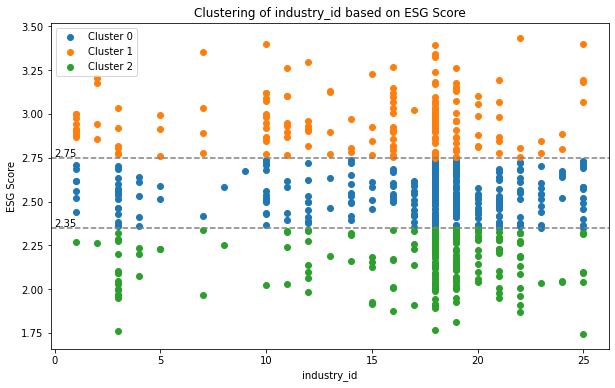

[2.53716513 2.95894068 2.15595672]


In [82]:
df2 = df[['industry_id','ESG_score']].copy()

numeric_df = df[['ESG_score']]  # Selecting only the ESG_score column for clustering

# Perform K-means clustering
kmeans = KMeans(n_clusters=3)  # Can adjust the number of clusters as needed
kmeans.fit(numeric_df)
labels = kmeans.labels_
centroids = kmeans.cluster_centers_
cluster_edges = [(centroids[0]+centroids[i+1])/2 for i in range(len(centroids)-1)]

# Add cluster labels to the DataFrame
df2['cluster'] = labels

# Plotting
plt.figure(figsize=(10, 6))

for i, edge in enumerate(cluster_edges):
    plt.axhline(y=edge[0], color='gray', linestyle='--')
    plt.text(0.5, edge[0], f'{edge[0]:.2f}', ha='center', va='bottom')

for cluster_label in df2['cluster'].unique():
    cluster_data = df2[df2['cluster'] == cluster_label]
    plt.scatter(cluster_data['industry_id'], cluster_data['ESG_score'], label=f'Cluster {cluster_label}')

plt.xlabel('industry_id')
plt.ylabel('ESG Score')
plt.title('Clustering of industry_id based on ESG Score')
plt.legend()
plt.show()

print(centroids[: ,0])

In [93]:
# Calculate the count of factories in each industry
industry_counts = df.groupby(['industry_id']).size().reset_index(name='樣本數')

# Calculate the mean scores for each industry
industry_scores = df.groupby(['industry_id']).agg({
    'E_score': 'mean',
    'S_score': 'mean',
    'G_score': 'mean',
    'ESG_score': 'mean'
}).reset_index()

# Merge counts and scores into a new DataFrame
industry_summary = pd.merge(industry_counts, industry_scores, on='industry_id')
industry_summary = industry_summary.round(4)

print(industry_summary)

    industry_id  樣本數  E_score  S_score  G_score  ESG_score
0             1   17   2.5882   3.3137   2.5441     2.7537
1             2    5   2.7000   3.1000   2.9500     2.8900
2             3   38   2.5329   2.2368   2.3421     2.3902
3             4    8   2.5781   2.2292   2.2812     2.3840
4             5    7   2.6250   2.5714   2.6071     2.6052
5             7    7   2.6607   2.9286   2.5357     2.6827
6             8    2   2.4375   2.0833   2.6250     2.4165
7             9    1   2.6250   3.0000   2.5000     2.6738
8            10   30   2.8333   2.8389   2.6833     2.7807
9            11   16   2.6719   2.8542   2.5625     2.6781
10           12   22   2.5114   2.6515   2.4545     2.5259
11           13    7   2.6786   2.7857   2.7857     2.7439
12           14   16   2.5469   2.5521   2.5781     2.5594
13           15   13   2.4615   2.4744   2.5000     2.4786
14           16   32   2.7305   2.6823   2.6250     2.6805
15           17   19   2.5197   2.2281   2.5132     2.44